In [14]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
import nltk as nltk
import math

import os
import cProfile, pstats, io
#import memory_profiler
import psutil

import gc

# Enabling eager execution and set other configurations

In [15]:
tf.enable_eager_execution()
process = psutil.Process(os.getpid())

In [16]:
print(process.memory_info().rss / (1024*1024), 'MB') # to get memory used by this process in MB
#https://stackoverflow.com/questions/938733/total-memory-used-by-python-process

#https://pypi.org/project/memory-profiler/ - did not use it

1167.45703125 MB


# Load Google vectors

In [17]:
UNK = '</s>'

dirname = os.getcwd()
googlePath = os.path.join(dirname, 'datasets/')
outfile = googlePath +'google_word_corpus.pic'

with open(outfile, 'rb') as pickle_file:    
    googleCorpus, google_corpus_word_to_int, google_corpus_int_to_word = pickle.load(pickle_file)
googleSet = pd.read_csv(googlePath+'GoogleNews-vectors-negative10.txt', sep=' ', header=None)
print(googleSet.shape)
print(googleSet.head())

googleWords = googleSet.iloc[:,0:1]
googleVectors = googleSet.iloc[:,1:]

(31462, 11)
     0         1         2         3         4         5         6         7   \
0  </s>  0.001129 -0.000896  0.000319  0.001534  0.001106 -0.001404 -0.000031   
1    in  0.070312  0.086914  0.087891  0.062500  0.069336 -0.108887 -0.081543   
2   for -0.011780 -0.047363  0.044678  0.063477 -0.018188 -0.063965 -0.001312   
3  that -0.015747 -0.028320  0.083496  0.050293 -0.110352  0.031738 -0.014221   
4    is  0.007050 -0.073242  0.171875  0.022583 -0.132812  0.198242  0.112793   

         8         9         10  
0 -0.000420 -0.000576  0.001076  
1 -0.154297  0.020752  0.131836  
2 -0.072266  0.064453  0.086426  
3 -0.089844  0.117676  0.118164  
4 -0.107910  0.071777  0.020874  


In [18]:
#UNK = '<unk>'

#glovePath = '/media/kandy/hdd/master-thesis/datasets/'
#outfile = glovePath +'glove_word_corpus.pic'

#with open(outfile, 'rb') as pickle_file:    
#    gloveCorpus, glove_corpus_word_to_int, glove_corpus_int_to_word = pickle.load(pickle_file)
#gloveSet = pd.read_csv(glovePath+'glove.42B.10d.txt', sep=' ', header=None)
#print(gloveSet.shape)
#print(gloveSet.head())

#gloveWords = gloveSet.iloc[:,0:1]
#gloveVectors = gloveSet.iloc[:,1:]

# Load training and test dataset

In [19]:
#treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-all-UNK.csv', sep=' ', header=None )
treeDataframe = pd.read_csv(googlePath+'constituency-parsing-data-all-UNK-less-40-words.csv', sep=' ', header=None )

treeDataframe.columns =['sentence', 'tree']
treeDataframe['tree'] = treeDataframe['tree'].apply(nltk.Tree.fromstring)

treeDataframe.head()

,sentence,tree
0,foresight,[[[foresight]]]
1,</s>,[[[daffynition]]]
2,municipals,[[[municipals]]]
3,</s>,[[[daffynition]]]
4,copper,[[[copper]]]


In [20]:
def convert_imdb_corpus_into_int(sentence):
    words = sentence.split()
    words_to_num = [google_corpus_word_to_int[word] for word in words]
    return words_to_num

treeDataframe_num = treeDataframe.copy()
treeDataframe_num['sentence'] = treeDataframe_num['sentence'].apply(convert_imdb_corpus_into_int)
treeDataframe_num.head()

,sentence,tree
0,[17326],[[[foresight]]]
1,[0],[[[daffynition]]]
2,[28714],[[[municipals]]]
3,[0],[[[daffynition]]]
4,[4554],[[[copper]]]


In [21]:
treeDF_train, treeDF_test = sklearn.model_selection.train_test_split(treeDataframe_num, test_size=0.2)
print(treeDF_train.shape)
print(treeDF_test.shape)

(35067, 2)
(8767, 2)


# Model and the Parameters

In [22]:
STATE_SIZE = 10
embeddings = tfe.Variable(name='embeddings', validate_shape= googleVectors.shape, 
                          initial_value=googleVectors.values, 
                          dtype=tf.float32, trainable=False)
w = tfe.Variable(name='w', validate_shape=(2*googleVectors.shape[1], STATE_SIZE), 
                 initial_value=0.01 * tf.random_normal(shape=(2*googleVectors.shape[1], STATE_SIZE)),
                 dtype=tf.float32)
b = tfe.Variable(name='b', validate_shape=(1, STATE_SIZE),
                 initial_value=0.01 * tf.random_normal(shape=(1, STATE_SIZE)),
                 dtype=tf.float32)

w_score = tfe.Variable(name='w_score', validate_shape=(STATE_SIZE, 1), 
                 initial_value=0.01 * tf.random_normal(shape=(STATE_SIZE, 1)),
                 dtype=tf.float32)
b_score = tfe.Variable(name='b_score', validate_shape=(1, 1),
                 initial_value=0.01 * tf.random_normal(shape=(1, 1)),
                 dtype=tf.float32)

#print(w)
#print(b)
#print(w_score)
#print(b_score)

In [23]:
print(embeddings.shape)
lookup = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int['</s>'])
lookup = tf.reshape(lookup, shape=(1, lookup.shape[0]))
print(lookup)

(31462, 10)
tf.Tensor(
[[ 1.1291504e-03 -8.9645386e-04  3.1852722e-04  1.5335083e-03
   1.1062622e-03 -1.4038086e-03 -3.0517578e-05 -4.1961670e-04
  -5.7601929e-04  1.0757446e-03]], shape=(1, 10), dtype=float32)


In [24]:
def compute_score_for_tree(tree, weights, embeddings, scores):
    if(type(tree[0]) == type('a string')):
        #print(tree.label() + ' : ' + tree[0])
        word = tree[0].lower()
        if(word not in google_corpus_word_to_int):
            #print('missing word:',word)
            word = '</s>'
        word_vector = tf.nn.embedding_lookup(embeddings, google_corpus_word_to_int[word])
        word_vector = tf.reshape(word_vector, shape=(1, word_vector.shape[0]))
        return word_vector
        #print('depth is reached !!!')
        #return

    #for i in range(len(tree)):
    #    print('Inside tree : '+ tree[i].label())
    #    compute_score_for_tree(tree[i], weights, embeddings)


        
    left = compute_score_for_tree(tree[0], weights, embeddings, scores)
    if(len(tree) !=2):
        return left

    right = compute_score_for_tree(tree[1], weights, embeddings, scores)
    words_concat = tf.concat([left, right], axis=0)
    #print(words_concat.shape)
    #print(left.shape, right.shape)
    words_concat = tf.reshape(words_concat, shape=(1, left.shape[1] + right.shape[1]))
    #print(words_concat)
    z = tf.matmul(words_concat, weights[0]) + weights[1]
    state_vec = tf.tanh(z)
    
    #print(state_vec)
    score = tf.matmul(state_vec, weights[2]) + weights[3]
    scores.append(score)
    return state_vec
    
    
for j in range(treeDF_train.shape[0]):
    tree = treeDF_train.iat[j,1]
    print(tree.leaves())
    scores = []
    tree.chomsky_normal_form()
    compute_score_for_tree(tree[0], [w,b,w_score,b_score], embeddings, scores)
    #print(sum(scores))
    total_score = tf.reduce_sum(tf.stack(scores))
    print(total_score)
    break
    


['</s>', '*', 'take', 'heart', '</s>', 'sports', 'fans', '</s>', '</s>', 'he', 'wrote', '*t*-1', '</s>']
tf.Tensor(-0.051878925, shape=(), dtype=float32)


In [25]:
def compare_trees(actual, predicted):
    actual_sub_trees = actual.subtrees()
    
    
    total_count = 0.0 #len(actual_sub_trees)
    match_count = 0.0
    
    for sub_tree in actual_sub_trees:
        #print('Sub Tree:', sub_tree)
        #print(predicted_sub_trees)
        predicted_sub_trees = predicted.subtrees()
        for temp_tree in predicted_sub_trees:
            #print(' ', temp_tree)
            if(sub_tree == temp_tree):
                match_count = match_count + 1.0
                break
        total_count = total_count + 1.0
        #break
    #print('Match:', match_count,' Total:', total_count)
    
    return [match_count/total_count, match_count, total_count]

#compare_trees(treeDF_train.iat[2,1], treeDF_train.iat[2,1])

t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
sub_trees = t1.subtrees()
for sub_tree in sub_trees:
    print(sub_tree)

(S (NP I) (VP (V saw) (NP him)))
(NP I)
(VP (V saw) (NP him))
(V saw)
(NP him)


In [26]:
#t1 = nltk.Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
#t2 = nltk.Tree.fromstring("(a (b I) (c (d saw) (e him)))")

#compare_trees(t1, t2)

In [27]:
pr = cProfile.Profile()
pr.enable()
# ... do something ...

In [28]:
def embedding_lookup(input_words):
    words = tf.nn.embedding_lookup(embeddings, input_words)
    return words

def forward_propagation(data):
    
    total_loss_list = []
    total_train_accuracy = 0.0
    total_train_count = 0.0

    for j in range(data.shape[0]):
        # get the word vectors based on the word ids (word id for each word)
        
        words = embedding_lookup(data.iat[j,0])

        end = timer()
        #print('Time taken to lookup embeddings (seconds): ', end-start)
        #words matrix - unstack
        words_unstack = tf.unstack(words)
        words_len = len(words_unstack)

        pred_score_list = []
        predicted_tree = [nltk.Tree(UNK,[google_corpus_int_to_word[index]]) for index in data.iat[j,0]]

        state_vec_list = []
        score_list = []

        start_k = 0
        stop_k = words_len - 1 
        #loop until all the words are merged together
        while(words_len > 1):
            #compute scores for the list of word combinations
            # for each word combination compute the score of it

            scores = np.zeros(shape=(words_len-1, 1))
            for k in range(start_k, stop_k):
                words_concat = tf.concat([words_unstack[k], words_unstack[k+1]], axis=0)
                #reshape the tensor to be a matrix with 1 row rather than vector
                words_concat = tf.reshape(words_concat, shape=(1, words_concat.shape[0]))
                # matrix computation and activation
                z = tf.matmul(words_concat, w) + b
                state_vec = tf.tanh(z)
                state_vec_list.append(state_vec)
                score = tf.matmul(state_vec, w_score) + b_score
                score_list.append(score)
                scores[k] = score

            end = timer()
            #print('Time taken to calculate all subsequent word combinations (seconds): ', end-start)

            #compare the scores and pick the maximum one. 
            max_score_index = np.argmax(scores) 
            pred_score_list.append(scores[max_score_index])

            # remove the words which is used to combine and replace with combined state vector
            words_unstack.pop(max_score_index+1)
            words_unstack.pop(max_score_index)
            # statevector needs to be reshaped as matrix to update
            state_vec_vector = tf.reshape(state_vec, shape = [state_vec.shape[1]])
            words_unstack.insert(max_score_index, state_vec_vector)
            words_len = len(words_unstack)

            right_tree = predicted_tree.pop(max_score_index+1)
            left_tree = predicted_tree.pop(max_score_index)
            predicted_tree.insert(max_score_index, nltk.Tree(UNK, [left_tree, right_tree]))

            start_k = max(0, max_score_index - 1)
            stop_k = min(max_score_index+2, words_len-1)

            #print([max_score_index, start_k, stop_k, words_len])

            end = timer()
            #print('Time taken to make one decision (seconds): ', end-start)

        end = timer()
        if (j%10 == 0):
            print(j,end-start, process.memory_info().rss / (1024*1024), 'MB')
        #if (epoch_arg%10 == 0):
        
        #print('Time taken to forward loop (seconds): ', end-start)
        # get the actual tree - convert it to chomsky normal form, and compute the score
        act_score_list = []
        tree = data.iat[j,1]
        tree.chomsky_normal_form()
        compute_score_for_tree(tree[0], [w,b,w_score,b_score], embeddings, act_score_list)
        end = timer()
        #print('Time taken to chomsky calculation (seconds): ', end-start)

        # compute the total actual and predicted score. use the loss function as absolute difference
        # the above is done for each training data and the loss are accumulated
        total_act_score = tf.reduce_sum(tf.stack(act_score_list))
        total_pred_score = tf.reduce_sum(tf.stack(pred_score_list))
        loss = tf.losses.absolute_difference(total_act_score,  total_pred_score)
        total_loss_list.append(loss)

        #loss = tf.losses.sigmoid_cross_entropy(tf.constant(imdb_train.iat[j,1], shape=(1,1)), y_predict)
        
        total_train_accuracy = total_train_accuracy + compare_trees(tree[0], predicted_tree[0])[0]
        total_train_count = total_train_count + 1
    return total_loss_list, total_train_accuracy/total_train_count



In [29]:
start = timer()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
epoch = 2

# history to maintain variables,  losses and gradients
variables_history = []
variables_history.append([np.copy(w.numpy()), np.copy(b.numpy()),np.copy(w_score.numpy()),np.copy(b_score.numpy())])

loss_history = []
grad_history = []

mini_batch_size = 50.0
with tf.device("/cpu:0"):
    for i in range(epoch):
        # to record the history of tensor computations
       
        print('Epoch : ', i)
        mini_batch_count = treeDF_train.shape[0] / mini_batch_size
        mini_batch_count = math.ceil(mini_batch_count)
        
        for j in range(mini_batch_count):
            
            print('Minibatch : ', j)
            mini_start = int(j*mini_batch_size)
            mini_stop = int(mini_start + mini_batch_size)
            mini_stop =  min(mini_stop, treeDF_train.shape[0])
            mini_batch_data = treeDF_train.iloc[mini_start:mini_stop]
            
            with tf.GradientTape() as tape:
                # watching - is it necessary ???
                #tape.watch([w,b,w_score,b_score])

                total_loss_list, accuracy = forward_propagation(mini_batch_data)

                # BACKWARD PASS
                # compute the average losses accompanying all training data
                # compute the gradients and apply them on variables

                total_loss = tf.reduce_mean(tf.stack(total_loss_list))
                grads = tape.gradient(total_loss, [w,b,w_score,b_score])

                #print(w[0])

                grad_op = optimizer.apply_gradients(zip(grads, [w,b,w_score,b_score]), 
                                          global_step=tf.train.get_or_create_global_step())

                #print(w[0])

                #maintain the history of variables, losses and gradients

                #variables_history.append([np.copy(w.numpy()), np.copy(b.numpy()),np.copy(w_score.numpy()),np.copy(b_score.numpy())])
                #loss_history.append(np.copy(total_loss.numpy()))
                #grad_history.append([np.copy(grad.numpy()) for grad in grads])

                #print(tf.train.get_or_create_global_step().numpy(),total_loss.numpy())

                gc.collect() # clearing the memory of variables
                print('Training Accuracy : ', accuracy)


    end = timer()
    print('Time taken to execute (seconds): ', end-start)

Epoch :  0
Minibatch :  0
0 0.09509310199973697 2303.63671875 MB
10 0.5899385409993556 2309.64453125 MB
20 1.2624420019992613 2317.9296875 MB
30 1.8462854209992656 2328.484375 MB
40 2.343157778999739 2331.54296875 MB
Training Accuracy :  0.4098467820251034
Minibatch :  1
0 4.186544129999675 2347.0625 MB
10 4.925548397000057 2347.0625 MB
20 5.644714151999324 2347.0625 MB
30 6.473916084999473 2347.3125 MB
40 7.271990487000039 2352.66015625 MB
Training Accuracy :  0.38825481960191455
Minibatch :  2
0 9.337236755999584 2364.1796875 MB
10 10.172405690999767 2364.1796875 MB
20 10.7139409779993 2364.1796875 MB
30 11.448830700999679 2364.1796875 MB
40 12.01808351499949 2364.1796875 MB
Training Accuracy :  0.39503676991141545
Minibatch :  3
0 13.738632003999555 2363.89453125 MB
10 14.430492323999715 2363.89453125 MB
20 15.050999799999772 2363.89453125 MB
30 15.602386269999442 2363.89453125 MB
40 16.426280431999658 2363.89453125 MB
Training Accuracy :  0.38728525584091295
Minibatch :  4
0 18.214

30 150.75695820700003 2375.20703125 MB
40 151.7050401309998 2375.20703125 MB
Training Accuracy :  0.38711111432386375
Minibatch :  34
0 153.7978961939998 2375.984375 MB
10 154.60800367999946 2375.984375 MB
20 155.47103117400002 2375.984375 MB
30 156.11168804999943 2375.984375 MB
40 157.08474819399999 2375.984375 MB
Training Accuracy :  0.3853631931182362
Minibatch :  35
0 159.02222221099964 2375.984375 MB
10 159.75184336499933 2375.984375 MB
20 160.38566912699935 2375.984375 MB
30 161.05897994299994 2375.984375 MB
40 161.74828070799958 2375.984375 MB
Training Accuracy :  0.3840736855879363
Minibatch :  36
0 163.69440474299972 2375.984375 MB
10 164.1235818589994 2375.984375 MB
20 164.99054852500012 2375.984375 MB
30 165.917042477 2375.984375 MB
40 166.62884137799938 2375.984375 MB
Training Accuracy :  0.3857705970773132
Minibatch :  37
0 168.42109343399989 2375.984375 MB
10 169.24176808999982 2375.984375 MB
20 169.87398458000007 2375.984375 MB
30 170.59111350900002 2375.984375 MB
40 171

KeyboardInterrupt: 

In [30]:
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())


         193595001 function calls (122560996 primitive calls) in 268.327 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       23    0.000    0.000  268.325   11.666 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/asyncio/base_events.py:1355(_run_once)
    17/11    0.000    0.000  244.870   22.261 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/tornado/gen.py:1115(run)
    26/15    0.000    0.000  244.870   16.325 {method 'send' of 'generator' objects}
       54    0.000    0.000  244.870    4.535 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/asyncio/events.py:143(_run)
    31/23    0.000    0.000  244.869   10.646 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/tornado/stack_context.py:296(null_wrapper)
       20    0.000    0.000  244.869   12.243 /home/kandy/anaconda3/envs/nlp-master-thesis/lib/python3.6/site-packages/tornado/ioloop.py:752(_run_

In [70]:
parameters = [w, b, w_score, b_score]
with open('parameters1.pic', 'wb') as pickle_file:    
    pickle.dump(parameters, pickle_file)

In [71]:
with open('parameters1.pic', 'rb') as pickle_file:    
    parameters_load = pickle.load(pickle_file)
    
parameters_load

[<tf.Variable 'Variable:0' shape=(20, 10) dtype=float32, numpy=
 array([[ 0.05449952, -0.05820941, -0.07479048,  0.07552884,  0.05367459,
         -0.08232174,  0.06850577,  0.053314  ,  0.06956143, -0.06835131],
        [-0.12762049,  0.19548291,  0.12795486, -0.12232459, -0.11488654,
          0.12882224, -0.13180259, -0.10274142, -0.1199842 ,  0.15152201],
        [-0.2716166 ,  0.21954337,  0.28029817, -0.2663605 , -0.2917365 ,
          0.29296908, -0.279158  , -0.29395953, -0.28435186,  0.24700654],
        [-0.11761219,  0.04319522,  0.13379812, -0.14193122, -0.15528771,
          0.16092966, -0.10037804, -0.13636182, -0.16434872,  0.07004908],
        [ 0.37635627, -0.33532643, -0.35114944,  0.35295287,  0.37265265,
         -0.3569482 ,  0.3477273 ,  0.3722801 ,  0.36238486, -0.34879985],
        [ 0.30905163, -0.3422345 , -0.2976176 ,  0.29200876,  0.27512342,
         -0.2821878 ,  0.31692556,  0.2887246 ,  0.26532975, -0.3419936 ],
        [ 0.1018302 , -0.10265553, -0.1052

In [25]:
treeDF_train['sentence'].shape

(43,)

In [26]:
treeDF_train['sentence'].apply(len)

10177    15
10775    16
12456    17
4583     10
23265    24
21356    22
654       4
16130    19
5935     12
35655    32
36737    33
16558    19
41668    38
23537    24
33335    30
40260    36
12044    16
5421     11
12007    16
26512    26
25376    25
41477    37
27721    26
27611    26
26241    25
36206    32
1886      7
29159    27
27265    26
2415      8
20167    22
7455     13
14233    18
9305     15
42871    39
40616    36
34505    31
18936    21
15556    19
8434     14
2667      8
33180    30
28116    27
Name: sentence, dtype: int64

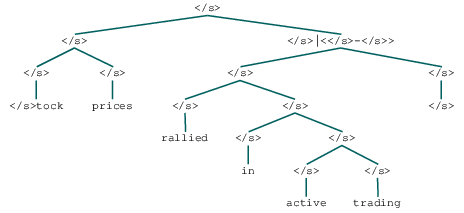

In [32]:
tree[0]

In [ ]:
predicted_tree[0]

In [ ]:
compare_trees(tree[0], predicted_tree[0])

In [ ]:
' '.join(tree[0].leaves())

* Improve parallelization through batch processing
* Implement CMY algorithm to reuse the computed values
* Preprocessing of tree (binary children, UNK words)

* check for this tree ('morgenzon has long been a special domain of afrikanerdom </s>')
* still missing word in compute_score_for_tree function. why? All preprocessign are good
* Other hyper parameters

* GPU usage

* Increase no. of units
* BEAM search
* Involve the classification of subcategories
* Assign different weights for different subcategories (atleast broader)

In [38]:
output = tf.gather([11,12,13,14,15,16,17,18,19,20],[[0,1],[1,2],[2,3],[3,4],[4,5]])
print(output)

tf.Tensor(
[[11 12]
 [12 13]
 [13 14]
 [14 15]
 [15 16]], shape=(5, 2), dtype=int32)


In [50]:
words = tf.nn.embedding_lookup(embeddings, treeDF_train.iat[0,0])
print(words.shape)
print(words[0:2])

(43, 10)
tf.Tensor(
[[ 9.5703125e-02 -3.8818359e-02  5.8837891e-02  3.9306641e-02
  -1.3000488e-02 -1.4843750e-01  7.5683594e-02 -1.3378906e-01
   2.8906250e-01  3.7078857e-03]
 [-1.0347366e-04  8.2492828e-05  1.5029907e-03  6.9046021e-04
   2.2983551e-04 -1.5487671e-03 -1.2435913e-03 -6.1035156e-04
   8.9645386e-04 -1.2893677e-03]], shape=(2, 10), dtype=float32)


In [47]:
output = tf.gather(words, [[[i], [i+1]] for i in range(0, words.shape[0]-1)], axis=0)
print(output.shape)
print(output[0])

tf.Tensor(
[[[ 9.5703125e-02 -3.8818359e-02  5.8837891e-02  3.9306641e-02
   -1.3000488e-02 -1.4843750e-01  7.5683594e-02 -1.3378906e-01
    2.8906250e-01  3.7078857e-03]]

 [[-1.0347366e-04  8.2492828e-05  1.5029907e-03  6.9046021e-04
    2.2983551e-04 -1.5487671e-03 -1.2435913e-03 -6.1035156e-04
    8.9645386e-04 -1.2893677e-03]]], shape=(2, 1, 10), dtype=float32)


In [49]:
tf.reshape(output[0], (2,10))

<tf.Tensor: id=4506393, shape=(2, 10), dtype=float32, numpy=
array([[ 9.5703125e-02, -3.8818359e-02,  5.8837891e-02,  3.9306641e-02,
        -1.3000488e-02, -1.4843750e-01,  7.5683594e-02, -1.3378906e-01,
         2.8906250e-01,  3.7078857e-03],
       [-1.0347366e-04,  8.2492828e-05,  1.5029907e-03,  6.9046021e-04,
         2.2983551e-04, -1.5487671e-03, -1.2435913e-03, -6.1035156e-04,
         8.9645386e-04, -1.2893677e-03]], dtype=float32)>